# Data Preparation Analysis
In this notebook, I have performed data preparation steps and analyzed data for modeling purposes.

## Table of Contents:
1. Data Loading
2. Removing Non-Meaningful Variables
3. Removing Erroneous Rows
4. Missing Values Treatment
    - Column: remaining_contract
    - Column: download_avg and upload_avg
5. Transforming data to Gaussian Distribution
    - Original Data
    - Yeo-Johnson Power Transformation
    - Yeo-Johnson Power Transformation on standardized data
    - Box-Cox Power Transformation
    - Normal Quantile Transformation
6. Exporting Processed Dataset

In [1]:
# Importing required libraries and modules
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, QuantileTransformer

In [2]:
# Setting seaborn figure size
sns.set(rc={'figure.figsize':(10,8)})

## Data Loading

In [3]:
train = pd.read_csv('../data/interim/train.csv')

In [4]:
print('Shape=>', train.shape)
train.head()

Shape=> (62274, 11)


,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,remaining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,1250624,1,1,1.77,7,0.19,0,114.1,8.7,0,0
1,1668176,1,0,0.05,6,0.59,0,12.7,1.3,0,0
2,1151155,0,0,1.42,18,NaN,0,0.4,0.0,0,1
3,1219428,1,0,0.73,20,0.00,0,9.3,0.4,0,1
4,1344910,1,0,0.25,17,0.00,0,6.1,0.5,0,1


In [5]:
# Getting an overview of the dataset
train.info(show_counts=True,verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62274 entries, 0 to 62273
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           62274 non-null  int64  
 1   is_tv_subscriber             62274 non-null  int64  
 2   is_movie_package_subscriber  62274 non-null  int64  
 3   subscription_age             62274 non-null  float64
 4   bill_avg                     62274 non-null  int64  
 5   remaining_contract           43701 non-null  float64
 6   service_failure_count        62274 non-null  int64  
 7   download_avg                 61949 non-null  float64
 8   upload_avg                   61949 non-null  float64
 9   download_over_limit          62274 non-null  int64  
 10  churn                        62274 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 5.2 MB


## Removing Non-Meaningful Variables

Among the 11 variables, **id** is an identifier variable and contains no information for predicting churn. Therefore, I'll drop it.

In [6]:
train.drop(columns=['id'], inplace=True)

## Removing Erroneous Rows

In [7]:
train.describe()

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,remaining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
count,62274.000000,62274.000000,62274.000000,62274.000000,43701.000000,62274.000000,61949.000000,61949.000000,62274.000000,62274.000000
mean,0.816344,0.334265,2.453485,18.943781,0.714611,0.275958,43.704287,4.185977,0.208080,0.554148
std,0.387207,0.471737,2.038194,13.263691,0.696947,0.823169,64.417559,9.801698,0.997159,0.497063
min,0.000000,0.000000,-0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.930000,13.000000,0.000000,0.000000,6.700000,0.500000,0.000000,0.000000
50%,1.000000,0.000000,1.980000,19.000000,0.570000,0.000000,27.700000,2.100000,0.000000,1.000000
75%,1.000000,1.000000,3.300000,22.000000,1.310000,0.000000,60.400000,4.800000,0.000000,1.000000
max,1.000000,1.000000,12.800000,406.000000,2.870000,19.000000,4415.200000,453.300000,7.000000,1.000000


The minimum value of *subscription_age* is -0.02 which isn't possible. So, let's take a look at the instances with less than 0 subscription age.

In [8]:
train[train['subscription_age']<0]

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,remaining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
44192,0,0,-0.02,0,0.08,0,32.6,1.3,0,1


Since we only have a single instance, we can simply remove it from our dataset.

In [9]:
# Removing instances with subscription_age less than 0
train = train[~(train['subscription_age']<0)]

## Missing Values Treatment
Let's now take a look at the number of missing values in every column.

In [10]:
train.isnull().sum()

is_tv_subscriber                   0
is_movie_package_subscriber        0
subscription_age                   0
bill_avg                           0
remaining_contract             18573
service_failure_count              0
download_avg                     325
upload_avg                       325
download_over_limit                0
churn                              0
dtype: int64

### Column: remaining_contract
The null values present in the *remaining_contract* columns are for those customers who are not in a contract. It is because there are two ways in which a customer could be using the services. One through a time-bound contract which costs less and another through a normal monthly subscription which obviously costs more. So even if a person is not in a contract, he's still a user who's paying monthly fees.

To handle the null_values in the *remaining_contract* column, I can create another dichotomous variable named *is_contract* that will have a value of 1 if the customer is in a contract else 0. And, for the null values in the *remaining_contract* column, I'll replace them with 0.

In [11]:
train_cols = train.columns.tolist()
train_cols.insert(5, 'is_contract')

# Creating is_contract column
train['is_contract'] = train['remaining_contract'].apply(lambda x: 0 if pd.isna(x) else 1)

# Imputing null values with 0
train['remaining_contract'].replace(np.nan, 0, inplace=True)

# Rearranging columns
train = train[train_cols]

In [12]:
# Getting an overview of the dataset
train.info(show_counts=True,verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62273 entries, 0 to 62273
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   is_tv_subscriber             62273 non-null  int64  
 1   is_movie_package_subscriber  62273 non-null  int64  
 2   subscription_age             62273 non-null  float64
 3   bill_avg                     62273 non-null  int64  
 4   remaining_contract           62273 non-null  float64
 5   is_contract                  62273 non-null  int64  
 6   service_failure_count        62273 non-null  int64  
 7   download_avg                 61948 non-null  float64
 8   upload_avg                   61948 non-null  float64
 9   download_over_limit          62273 non-null  int64  
 10  churn                        62273 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 5.7 MB


In [13]:
train.isnull().sum()

is_tv_subscriber                 0
is_movie_package_subscriber      0
subscription_age                 0
bill_avg                         0
remaining_contract               0
is_contract                      0
service_failure_count            0
download_avg                   325
upload_avg                     325
download_over_limit              0
churn                            0
dtype: int64

In [14]:
pd.crosstab(train['is_contract'], train['churn'])

churn,0,1
is_contract,,
0,1596,16977
1,26169,17531


It is clearly evident from the crosstab that customers who are not in a contract are more likely to churn. Now, it's time to handle missing values in the remainnig columns.

### Column: download_avg and upload_avg

<AxesSubplot:>

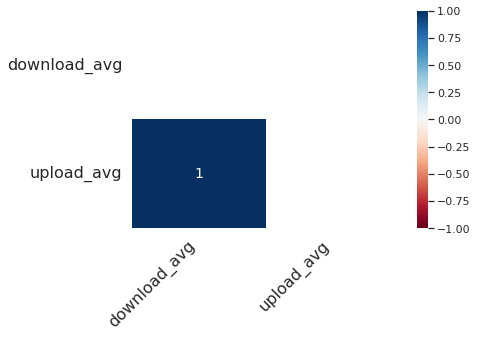

In [15]:
msno.heatmap(train, figsize=(6, 4))

Through the heatmap, we can see that missing values in both download_avg and upload_avg columns occur simultaneously. We need to investigate further to understand the reason behind their occurrence.

In [16]:
missing_usage_rows = train[train.isnull().any(axis=1)]
missing_usage_rows

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,remaining_contract,is_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
60,1,0,0.02,0,0.89,1,0,NaN,NaN,0,0
301,1,0,0.01,0,0.57,1,0,NaN,NaN,0,0
332,0,0,0.00,0,1.97,1,0,NaN,NaN,0,0
436,1,0,0.02,0,1.95,1,0,NaN,NaN,0,0
601,0,0,0.02,0,1.95,1,0,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...
61242,1,0,3.97,24,0.00,0,0,NaN,NaN,0,0
61467,1,1,0.02,0,1.96,1,0,NaN,NaN,0,0
61702,1,1,0.02,0,1.95,1,0,NaN,NaN,0,0
62165,1,0,6.87,12,0.00,0,0,NaN,NaN,0,0


In [17]:
missing_usage_rows['churn'].value_counts()

0    325
Name: churn, dtype: int64

All the rows with missing values in the *download_avg* and *upload_avg* column are customers who didn't churn. Since both *download_avg* and *upload_avg* are numerical variables and don't follow a gaussian distribution, we can impute them using the median.

Since I plan to split the training data into training and validation sets and then perform cross-validation on it, imputing values now will cause data leakage. Therefore, I will export the data processed till now, import it again during the modelling phase and make imputation a part of the modelling pipeline. It will help me avoid data leakage and prepare the model in the best way possible.

## Transforming data to Gaussian Distribution
During the Exploratory Data Analysis, we saw that none of the numerical variables followed a Gaussian Distribution, and the scale was very different among variables. Non-linear algorithms like Decision Trees are not affected by this but, linear algorithms such as Logistic Regression and those based on distance like KNN work much better when the input numeric variables follow a Gaussian Distribution and are on the same scale.

Therefore, I will compare different transformations on numeric variables, visualize the results, pick the best one and use it for model building. But first, let's look at the original data once again.

In [18]:
numerical_cols = ['subscription_age', 'bill_avg', 'remaining_contract',
                  'service_failure_count', 'download_avg', 'upload_avg',
                  'download_over_limit']

### Original Data

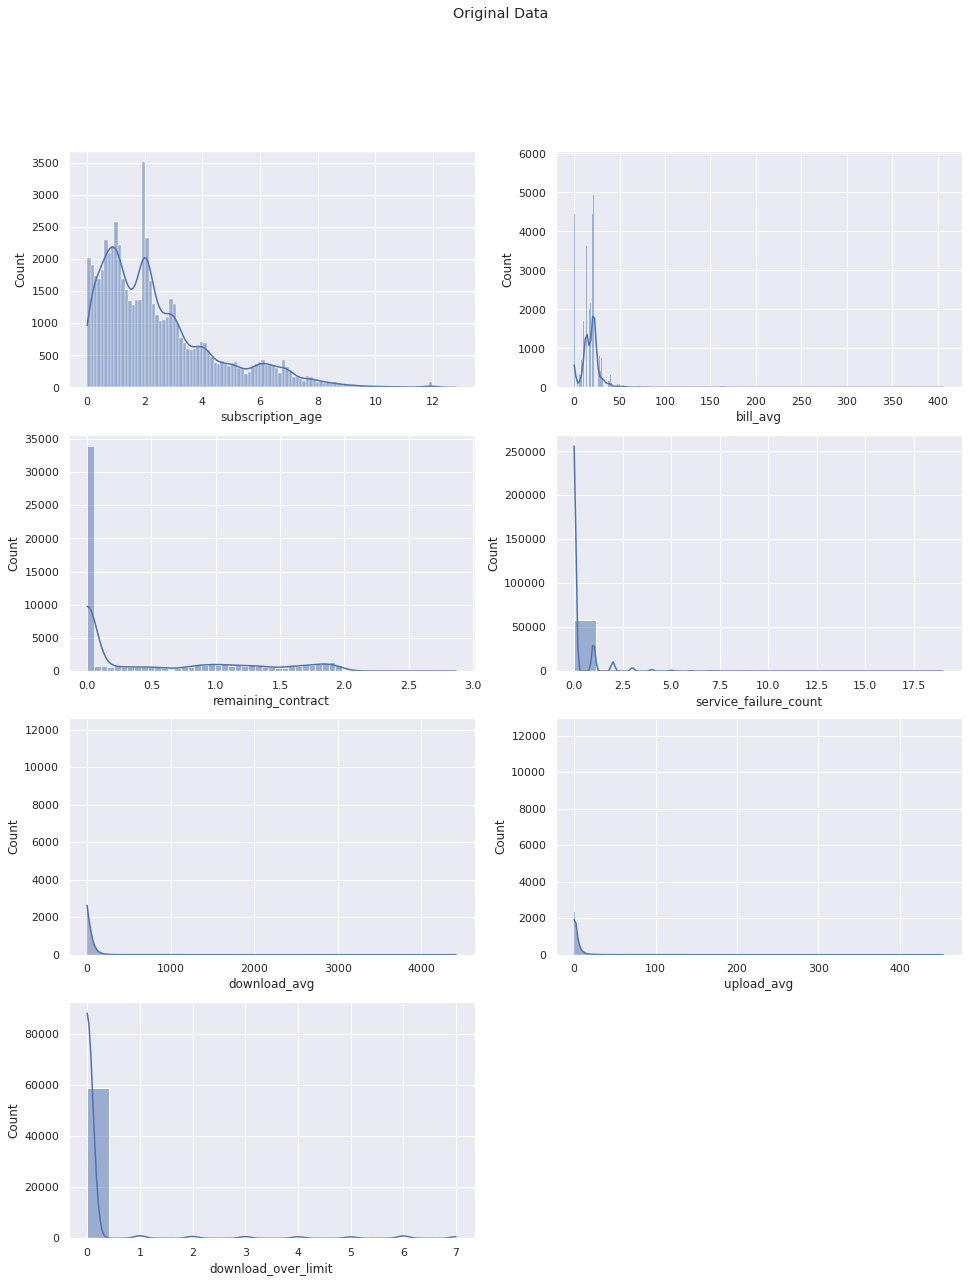

In [19]:
# Data without any Transformation
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.delaxes(axes[3,1])
fig.suptitle('Original Data')

for ax, col in zip(axes.flatten(), numerical_cols):
    sns.histplot(data=train, x=f'{col}', ax=ax, kde=True)
plt.show()

### Yeo-Johnson Power Transformation
Let's first try Yeo-Johnson Power Transformation and visualize the results.

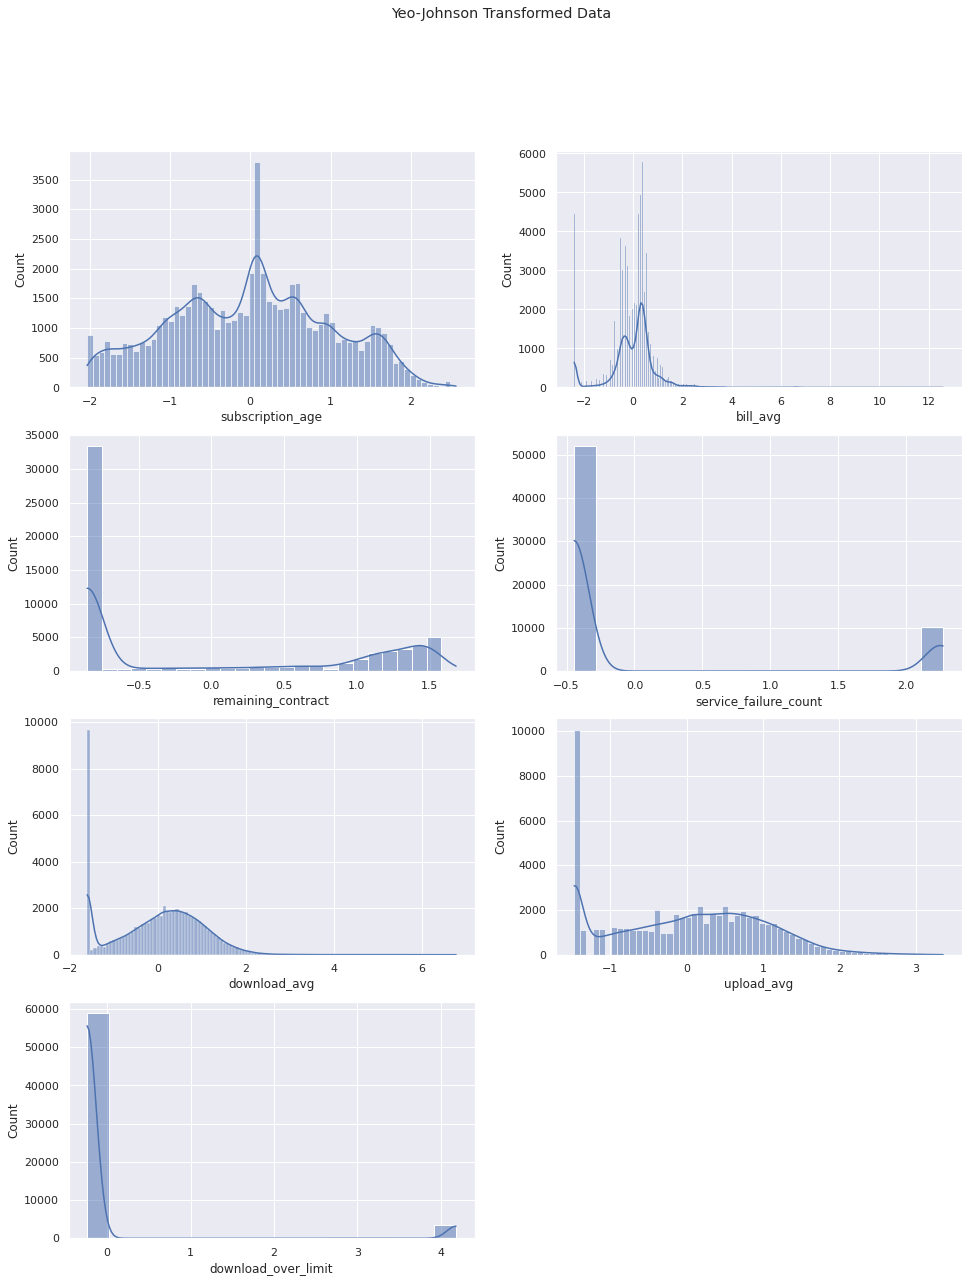

In [20]:
# Using Yeo-Johnson Power Transformer
X_yeo = train.loc[:, numerical_cols]

# Building Transformation Pipeline
imputer = SimpleImputer(strategy='median')
yeo_transformer = PowerTransformer(method = 'yeo-johnson')
transformer_pipeline = Pipeline(steps = [('median_imputer', imputer),
                                         ('yeo_transformer', yeo_transformer)])

# Applying Transformation
X_yeo = transformer_pipeline.fit_transform(X_yeo)
X_yeo = pd.DataFrame(data = X_yeo, columns = numerical_cols)

# Plotting Results
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.delaxes(axes[3,1])
fig.suptitle('Yeo-Johnson Transformed Data')

for ax, col in zip(axes.flatten(), numerical_cols):
    sns.histplot(data=X_yeo, x=f'{col}', ax=ax, kde=True)
plt.show()

### Yeo-Johnson Power Transformation on standardized data
Sometimes Yeo-Johnson works better when the data is first standardized and then passed for transformation. So let's try that.

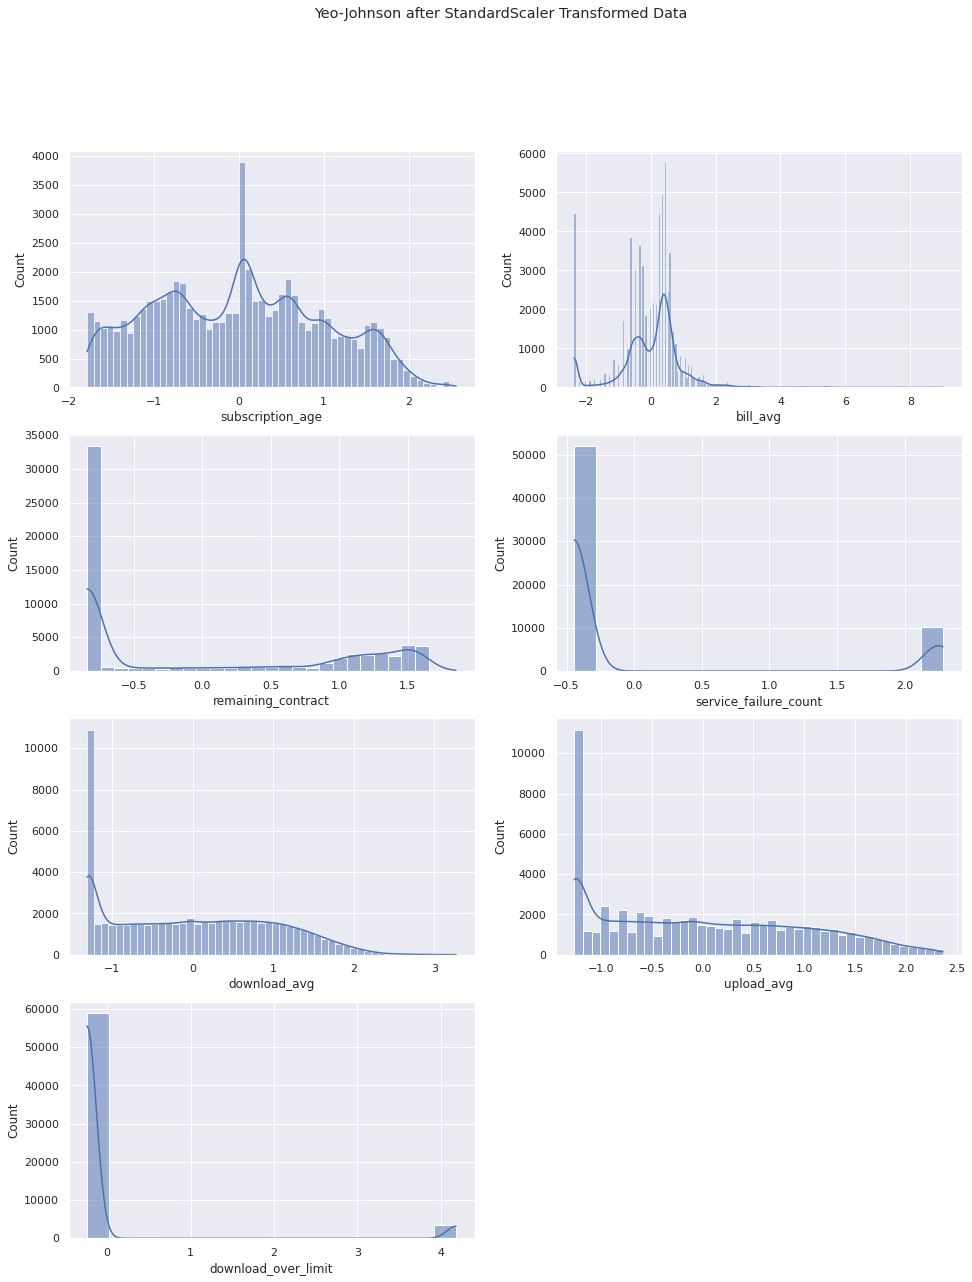

In [21]:
# Using Yeo-Johnson Power Transformer with standardscaler
X_yeo_scaled = train.loc[:, numerical_cols]

# Building Transformation Pipeline
scaler = StandardScaler()
imputer = SimpleImputer(strategy='median')
transformer = PowerTransformer(method = 'yeo-johnson')
transformer_pipeline = Pipeline(steps = [('median_imputer', imputer),
                                         ('standard_scaler', scaler),
                                         ('yeo_transformer', transformer)])

# Applying Transformation
X_yeo_scaled = transformer_pipeline.fit_transform(X_yeo_scaled)
X_yeo_scaled = pd.DataFrame(data = X_yeo_scaled, columns = numerical_cols)

# Plotting Results
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.delaxes(axes[3,1])
fig.suptitle('Yeo-Johnson after StandardScaler Transformed Data')

for ax, col in zip(axes.flatten(), numerical_cols):
    sns.histplot(data=X_yeo_scaled, x=f'{col}', ax=ax, kde=True)
plt.show()

### Box-Cox Power Transformation
Although Box-Cox transformation requires the data to be strictly positive, we can still apply it in our case by scaling our variables from 1 to 2 using a MinMaxScaler and then applying the transformer.

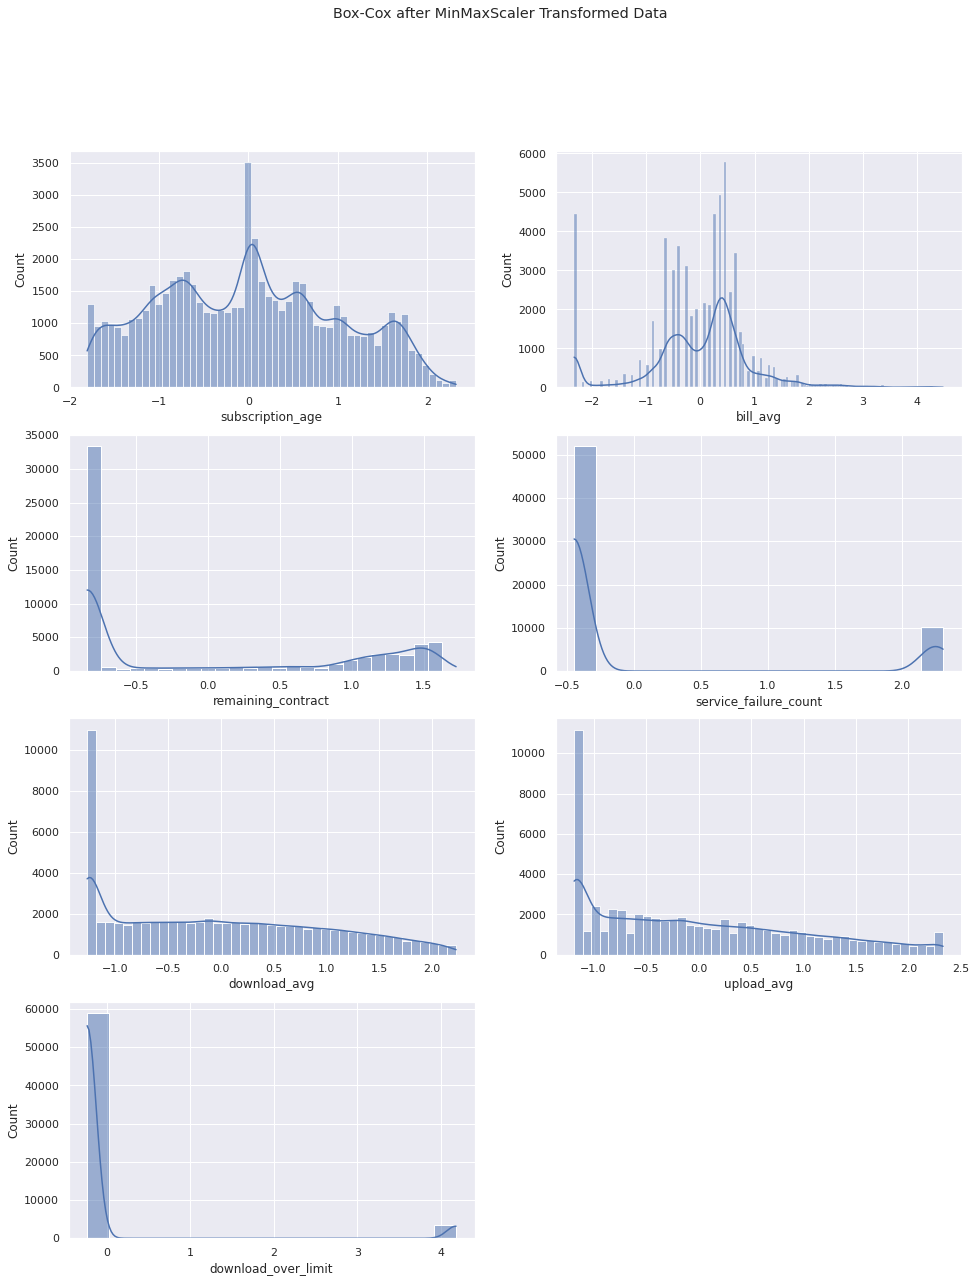

In [22]:
# Using Box-Cox Power Transformer with standardscaler
X_box = train.loc[:, numerical_cols]

# Building Transformation Pipeline
imputer = SimpleImputer(strategy='median')
scaler = MinMaxScaler(feature_range=(1, 2))
transformer = PowerTransformer(method = 'box-cox')
transformer_pipeline = Pipeline(steps = [('median_imputer', imputer),
                                         ('minmax_scaler', scaler),
                                         ('box_cox_transformer', transformer)])

# Applying Transformation
X_box = transformer_pipeline.fit_transform(X_box)
X_box = pd.DataFrame(data = X_box, columns = numerical_cols)

# Plotting Results
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.delaxes(axes[3,1])
fig.suptitle('Box-Cox after MinMaxScaler Transformed Data')

for ax, col in zip(axes.flatten(), numerical_cols):
    sns.histplot(data=X_box, x=f'{col}', ax=ax, kde=True)
plt.show()

### Normal Quantile Transformation
Till now, I have used parametric methods of transformation for transforming our numeric variables to Gaussian Distribution. Now let's use the QuantileTransformer which is a non-parametric method used for transforming the data to Gaussian.

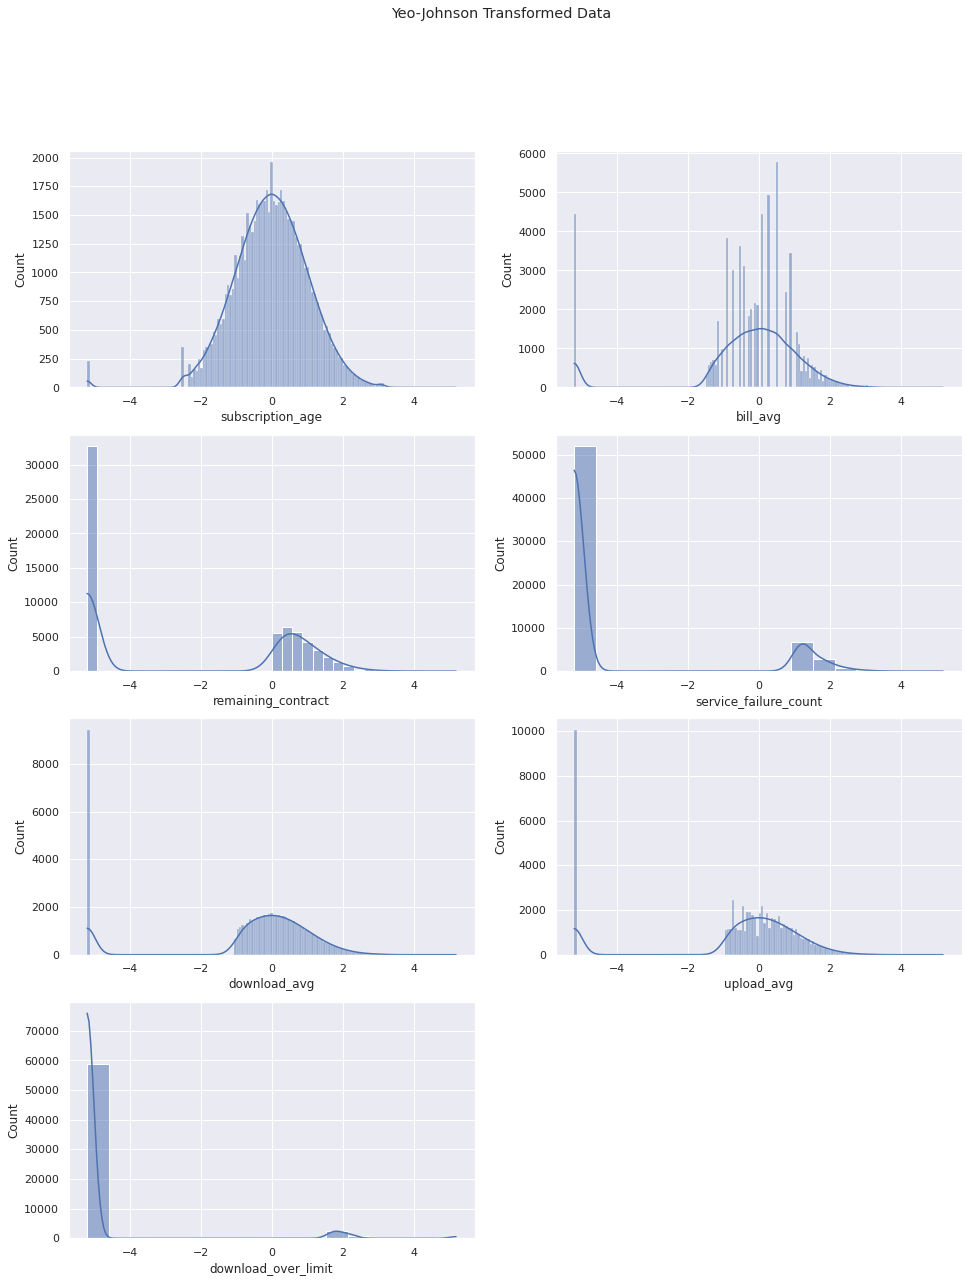

In [23]:
# Using Normal Quantile Transformer
X_quant = train.loc[:, numerical_cols]

# Building Transformation Pipeline
imputer = SimpleImputer(strategy='median')
quant_transformer = QuantileTransformer(n_quantiles=1000,
                                        output_distribution='normal',
                                        random_state=42)
transformer_pipeline = Pipeline(steps = [('median_imputer', imputer),
                                         ('quant_transformer', quant_transformer)])

# Applying Transformation
X_quant = transformer_pipeline.fit_transform(X_quant)
X_quant = pd.DataFrame(data = X_quant, columns = numerical_cols)

# Plotting Results
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.delaxes(axes[3,1])
fig.suptitle('Yeo-Johnson Transformed Data')

for ax, col in zip(axes.flatten(), numerical_cols):
    sns.histplot(data=X_quant, x=f'{col}', ax=ax, kde=True)
plt.show()

Among all the transformations tried so far, the results produced by Quantile Transformation look most promising. Therefore, I'll use Normal Quantile Transformation during model building.

## Exporting Processed Dataset

In [24]:
train.to_csv('../data/processed/train-prepared.csv', index=False)